In [1]:
# Setup: Add src to path and create directories
import sys, os
sys.path.insert(0, os.path.join('..', 'src'))
for d in ['results', 'models']: 
    os.makedirs(f'../{d}', exist_ok=True)
print("✅ Setup complete: paths and directories ready")


✅ Setup complete: paths and directories ready


In [2]:
# ─────────────────────────────────────────────────────────────────────────
#  MODEL EXPERIMENTS - CLASSIFICATION MODELS EVALUATION
# ─────────────────────────────────────────────────────────────────────────

"""
This script evaluates different classification models to determine whether a product is new or used.
The objective is to find the best model that minimizes false negatives (new products classified as used)
which have a high business cost.

Models evaluated:
- Logistic Regression
- Random Forest
- XGBoost  
- LightGBM
- Multi-Layer Perceptron (MLP)

The evaluation focuses on:
- Recall for 'new' class (critical business metric)
- ROC-AUC (good for imbalanced data)
- Overall performance metrics
- Overfitting analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# Metrics and evaluation
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, f1_score, 
    confusion_matrix, precision_score, recall_score, roc_curve, 
    precision_recall_curve, average_precision_score
)

# Import our pipeline
from feature_engineering_pipeline import make_full_pipeline
from new_or_used import build_dataset

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
def load_and_prepare_data():
    """Load and prepare the dataset using our feature engineering pipeline"""
    print("Loading and preparing data...")
    
    # Load raw data
    X_train_raw, y_train, X_test_raw, y_test = build_dataset()
    
    # Convert to DataFrames
    def dicts_to_df(dict_list):
        return pd.json_normalize(dict_list, sep='_')
    
    df_train = dicts_to_df(X_train_raw)
    df_test = dicts_to_df(X_test_raw)
    
    # Convert target to binary (1=new, 0=used)
    y_train_binary = (pd.Series(y_train) == "new").astype(int)
    y_test_binary = (pd.Series(y_test) == "new").astype(int)
    
    print(f"Training data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")
    print(f"Class distribution in training: {y_train_binary.value_counts().to_dict()}")
    print(f"Class distribution in test: {y_test_binary.value_counts().to_dict()}")
    
    return df_train, df_test, y_train_binary, y_test_binary

In [4]:
def apply_feature_engineering(df_train, df_test, y_train_binary):
    """Apply our feature engineering pipeline"""
    print("Applying feature engineering pipeline...")
    
    # Create pipeline
    pipeline = make_full_pipeline(target_name='condition')
    
    # Remove target column from training data if it exists
    X_train_raw = df_train.drop(columns=['condition']) if 'condition' in df_train.columns else df_train
    
    # Fit and transform training data
    X_train_processed = pipeline.fit_transform(X_train_raw, y_train_binary)
    
    # Transform test data
    X_test_processed = pipeline.transform(df_test)
    
    print(f"Processed training data shape: {X_train_processed.shape}")
    print(f"Processed test data shape: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, pipeline

In [5]:
def train_model(model, X_train, y_train, model_name):
    """Train a model and return the trained model"""
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    return model

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Comprehensive model evaluation with business metrics focus"""
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Get probabilities
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics for test set
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_test),
        'f1_score': f1_score(y_test, y_pred_test),
        'f1_weighted': f1_score(y_test, y_pred_test, average='weighted'),
        'f1_macro': f1_score(y_test, y_pred_test, average='macro'),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'avg_precision': average_precision_score(y_test, y_pred_proba_test)
    }
    
    # Calculate metrics for training set
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'roc_auc': roc_auc_score(y_train, y_pred_proba_train),
        'f1_score': f1_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train),
        'recall': recall_score(y_train, y_pred_train)
    }
    
    # Calculate overfitting metrics
    overfitting_metrics = {
        'accuracy_diff': train_metrics['accuracy'] - test_metrics['accuracy'],
        'roc_auc_diff': train_metrics['roc_auc'] - test_metrics['roc_auc'],
        'f1_diff': train_metrics['f1_score'] - test_metrics['f1_score'],
        'precision_diff': train_metrics['precision'] - test_metrics['precision'],
        'recall_diff': train_metrics['recall'] - test_metrics['recall']
    }
    
    overfitting_metrics['avg_diff'] = np.mean([
        overfitting_metrics['accuracy_diff'],
        overfitting_metrics['roc_auc_diff'],
        overfitting_metrics['f1_diff']
    ])
    
    # Assess overfitting
    if overfitting_metrics['avg_diff'] > 0.05:
        overfitting_status = "HIGH_OVERFITTING"
    elif overfitting_metrics['avg_diff'] > 0.02:
        overfitting_status = "MODERATE_OVERFITTING"
    else:
        overfitting_status = "GOOD_GENERALIZATION"
    
    # Confusion matrix analysis
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    
    # Business-critical metrics
    used_recall = tn / (tn + fp) if (tn + fp) > 0 else 0    # Recall for "used" class
    new_recall = tp / (tp + fn) if (tp + fn) > 0 else 0     # Recall for "new" class - CRITICAL
    
    # Compile all metrics
    all_metrics = {
        'model_name': model_name,
        **test_metrics,
        **{f'train_{k}': v for k, v in train_metrics.items()},
        **overfitting_metrics,
        'overfitting_status': overfitting_status,
        'used_recall': used_recall,
        'new_recall': new_recall,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }
    
    return all_metrics, y_pred_test, y_pred_proba_test

In [7]:
def print_model_evaluation(metrics, y_test, y_pred, y_pred_proba):
    """Print detailed evaluation results for a model"""
    
    model_name = metrics['model_name']
    
    print(f"\n{'='*60}")
    print(f"  {model_name.upper()} EVALUATION RESULTS")
    print(f"{'='*60}")
    
    # Main metrics
    print(f"\nTEST SET PERFORMANCE:")
    print(f"  Accuracy:     {metrics['accuracy']:.4f}")
    print(f"  ROC-AUC:      {metrics['roc_auc']:.4f}")
    print(f"  F1-Score:     {metrics['f1_score']:.4f}")
    print(f"  F1-Weighted:  {metrics['f1_weighted']:.4f}")
    print(f"  F1-Macro:     {metrics['f1_macro']:.4f}")
    print(f"  Precision:    {metrics['precision']:.4f}")
    print(f"  Recall:       {metrics['recall']:.4f}")
    print(f"  Avg Precision: {metrics['avg_precision']:.4f}")
    
    # Business metrics
    print(f"\nBUSINESS METRICS:")
    print(f"  Used Recall (detect used correctly):  {metrics['used_recall']:.4f}")
    print(f"  New Recall (detect new correctly):   {metrics['new_recall']:.4f} [CRITICAL]")
    print(f"  New products misclassified as used:  {(1-metrics['new_recall'])*100:.1f}%")
    
    # Overfitting analysis
    print(f"\nOVERFITTING ANALYSIS:")
    print(f"  Status: {metrics['overfitting_status']}")
    print(f"  Average difference (train-test): {metrics['avg_diff']:+.4f}")
    print(f"  Accuracy difference:  {metrics['accuracy_diff']:+.4f}")
    print(f"  ROC-AUC difference:   {metrics['roc_auc_diff']:+.4f}")
    print(f"  F1 difference:        {metrics['f1_diff']:+.4f}")
    
    # Confusion matrix
    print(f"\nCONFUSION MATRIX:")
    print(f"  True Negatives (TN):  {metrics['tn']} - Correctly predicted as Used")
    print(f"  False Positives (FP): {metrics['fp']} - Incorrectly predicted as New")
    print(f"  False Negatives (FN): {metrics['fn']} - Incorrectly predicted as Used [CRITICAL]")
    print(f"  True Positives (TP):  {metrics['tp']} - Correctly predicted as New")
    
    # Classification report
    print(f"\nCLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=["Used", "New"]))
    
    # Threshold analysis for achieving 95% new recall
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    recall_target = 0.95
    if max(recall_curve) >= recall_target:
        valid_indices = recall_curve >= recall_target
        if valid_indices.any():
            valid_precisions = precision_curve[valid_indices]
            best_idx = np.argmax(valid_precisions)
            optimal_recall = recall_curve[valid_indices][best_idx]
            optimal_precision = precision_curve[valid_indices][best_idx]
            optimal_threshold = thresholds[np.where(valid_indices)[0][best_idx]] if best_idx < len(thresholds) else 0.5
            
            print(f"\nTHRESHOLD OPTIMIZATION:")
            print(f"  For ≥95% New Recall:")
            print(f"    Optimal Threshold: {optimal_threshold:.4f}")
            print(f"    Achievable Precision: {optimal_precision:.4f}")
            print(f"    Achievable Recall: {optimal_recall:.4f}")
    else:
        print(f"\nTHRESHOLD OPTIMIZATION:")
        print(f"  Cannot achieve ≥95% New Recall")
        print(f"  Maximum achievable recall: {max(recall_curve):.4f}")

In [8]:
def plot_model_comparison(all_metrics):
    """Create visualization comparing all models"""
    
    df_results = pd.DataFrame(all_metrics)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Comparison Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Main Performance Metrics
    metrics_to_plot = ['accuracy', 'roc_auc', 'f1_score', 'recall']
    x_pos = np.arange(len(df_results))
    
    ax1 = axes[0, 0]
    width = 0.2
    for i, metric in enumerate(metrics_to_plot):
        ax1.bar(x_pos + i*width, df_results[metric], width, 
                label=metric.replace('_', ' ').title(), alpha=0.8)
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics Comparison')
    ax1.set_xticks(x_pos + width*1.5)
    ax1.set_xticklabels(df_results['model_name'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Business Critical Metrics
    ax2 = axes[0, 1]
    x_pos = np.arange(len(df_results))
    
    ax2.bar(x_pos - 0.2, df_results['used_recall'], 0.4, 
            label='Used Recall', alpha=0.8, color='orange')
    ax2.bar(x_pos + 0.2, df_results['new_recall'], 0.4, 
            label='New Recall (Critical)', alpha=0.8, color='red')
    
    ax2.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='Target: 95%')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Recall Score')
    ax2.set_title('Business Critical Metrics')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_results['model_name'], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Overfitting Analysis
    ax3 = axes[1, 0]
    colors = ['green' if status == 'GOOD_GENERALIZATION' 
              else 'orange' if status == 'MODERATE_OVERFITTING' 
              else 'red' for status in df_results['overfitting_status']]
    
    bars = ax3.bar(df_results['model_name'], df_results['avg_diff'], 
                   color=colors, alpha=0.7)
    ax3.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Moderate threshold')
    ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='High threshold')
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Average Difference (Train - Test)')
    ax3.set_title('Overfitting Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    
    # 4. Model Ranking
    ax4 = axes[1, 1]
    
    # Calculate composite score (weighted)
    df_results['composite_score'] = (
        0.3 * df_results['roc_auc'] + 
        0.4 * df_results['new_recall'] + 
        0.2 * df_results['f1_weighted'] + 
        0.1 * (1 - df_results['avg_diff'].clip(0, 1))  # Penalize overfitting
    )
    
    df_sorted = df_results.sort_values('composite_score', ascending=True)
    
    bars = ax4.barh(df_sorted['model_name'], df_sorted['composite_score'], 
                    color='skyblue', alpha=0.8)
    ax4.set_xlabel('Composite Score')
    ax4.set_title('Overall Model Ranking')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

In [9]:
def create_comparison_table(all_metrics):
    """Create a comprehensive comparison table"""
    
    df_results = pd.DataFrame(all_metrics)
    
    # Select key metrics for display
    display_cols = [
        'model_name', 'accuracy', 'roc_auc', 'f1_score', 'f1_weighted', 
        'precision', 'recall', 'new_recall', 'avg_diff', 'overfitting_status'
    ]
    
    df_display = df_results[display_cols].copy()
    
    # Round numeric columns
    numeric_cols = ['accuracy', 'roc_auc', 'f1_score', 'f1_weighted', 
                   'precision', 'recall', 'new_recall', 'avg_diff']
    df_display[numeric_cols] = df_display[numeric_cols].round(4)
    
    print(f"\n{'='*100}")
    print(f"                           COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*100}")
    print(df_display.to_string(index=False))
    
    # Find best models
    best_roc_auc = df_results.loc[df_results['roc_auc'].idxmax()]
    best_new_recall = df_results.loc[df_results['new_recall'].idxmax()]
    best_f1_weighted = df_results.loc[df_results['f1_weighted'].idxmax()]
    best_generalization = df_results.loc[df_results['avg_diff'].idxmin()]
    
    print(f"\n{'='*100}")
    print(f"                              KEY RECOMMENDATIONS")
    print(f"{'='*100}")
    print(f"Best ROC-AUC (overall discrimination):     {best_roc_auc['model_name']} ({best_roc_auc['roc_auc']:.4f})")
    print(f"Best New Recall (critical for business):  {best_new_recall['model_name']} ({best_new_recall['new_recall']:.4f})")
    print(f"Best F1-Weighted (balanced performance):   {best_f1_weighted['model_name']} ({best_f1_weighted['f1_weighted']:.4f})")
    print(f"Best Generalization (least overfitting):  {best_generalization['model_name']} ({best_generalization['avg_diff']:+.4f})")
    
    # Business recommendation
    good_generalization = df_results[df_results['avg_diff'] <= 0.02]
    if not good_generalization.empty:
        recommended = good_generalization.loc[good_generalization['new_recall'].idxmax()]
        print(f"\n🎯 BUSINESS RECOMMENDATION:")
        print(f"   Model: {recommended['model_name']}")
        print(f"   Rationale: Best New Recall ({recommended['new_recall']:.4f}) + Good Generalization ({recommended['avg_diff']:+.4f})")
        print(f"   Business Impact: {recommended['new_recall']*100:.1f}% new products correctly identified")
        print(f"   Risk: {(1-recommended['new_recall'])*100:.1f}% new products misclassified as used")
        
        if recommended['new_recall'] >= 0.95:
            print(f"   ✅ MEETS business target of ≥95% new recall")
        else:
            print(f"   ⚠️  BELOW business target of ≥95% new recall - consider threshold optimization")
    else:
        print(f"\n⚠️  All models show overfitting. Consider:")
        print(f"   - Regularization techniques")
        print(f"   - More training data")
        print(f"   - Feature selection")
        print(f"   - Hyperparameter tuning")
    
    return df_display

           PRODUCT CONDITION CLASSIFICATION - MODEL EXPERIMENTS
Objective: Find the best model to classify products as 'new' or 'used'
Critical Business Metric: Minimize new products classified as used
Loading and preparing data...


INFO:feature_engineering_pipeline:Creating feature engineering pipeline


Training data shape: (90000, 56)
Test data shape: (10000, 55)
Class distribution in training: {1: 48352, 0: 41648}
Class distribution in test: {1: 5406, 0: 4594}
Applying feature engineering pipeline...
Processed training data shape: (90000, 44)
Processed test data shape: (10000, 44)
Training Logistic Regression...

  LOGISTIC REGRESSION EVALUATION RESULTS

TEST SET PERFORMANCE:
  Accuracy:     0.8378
  ROC-AUC:      0.9155
  F1-Score:     0.8465
  F1-Weighted:  0.8380
  F1-Macro:     0.8373
  Precision:    0.8664
  Recall:       0.8276
  Avg Precision: 0.9271

BUSINESS METRICS:
  Used Recall (detect used correctly):  0.8498
  New Recall (detect new correctly):   0.8276 [CRITICAL]
  New products misclassified as used:  17.2%

OVERFITTING ANALYSIS:
  Status: GOOD_GENERALIZATION
  Average difference (train-test): +0.0017
  Accuracy difference:  +0.0019
  ROC-AUC difference:   +0.0015
  F1 difference:        +0.0016

CONFUSION MATRIX:
  True Negatives (TN):  3904 - Correctly predicted as 

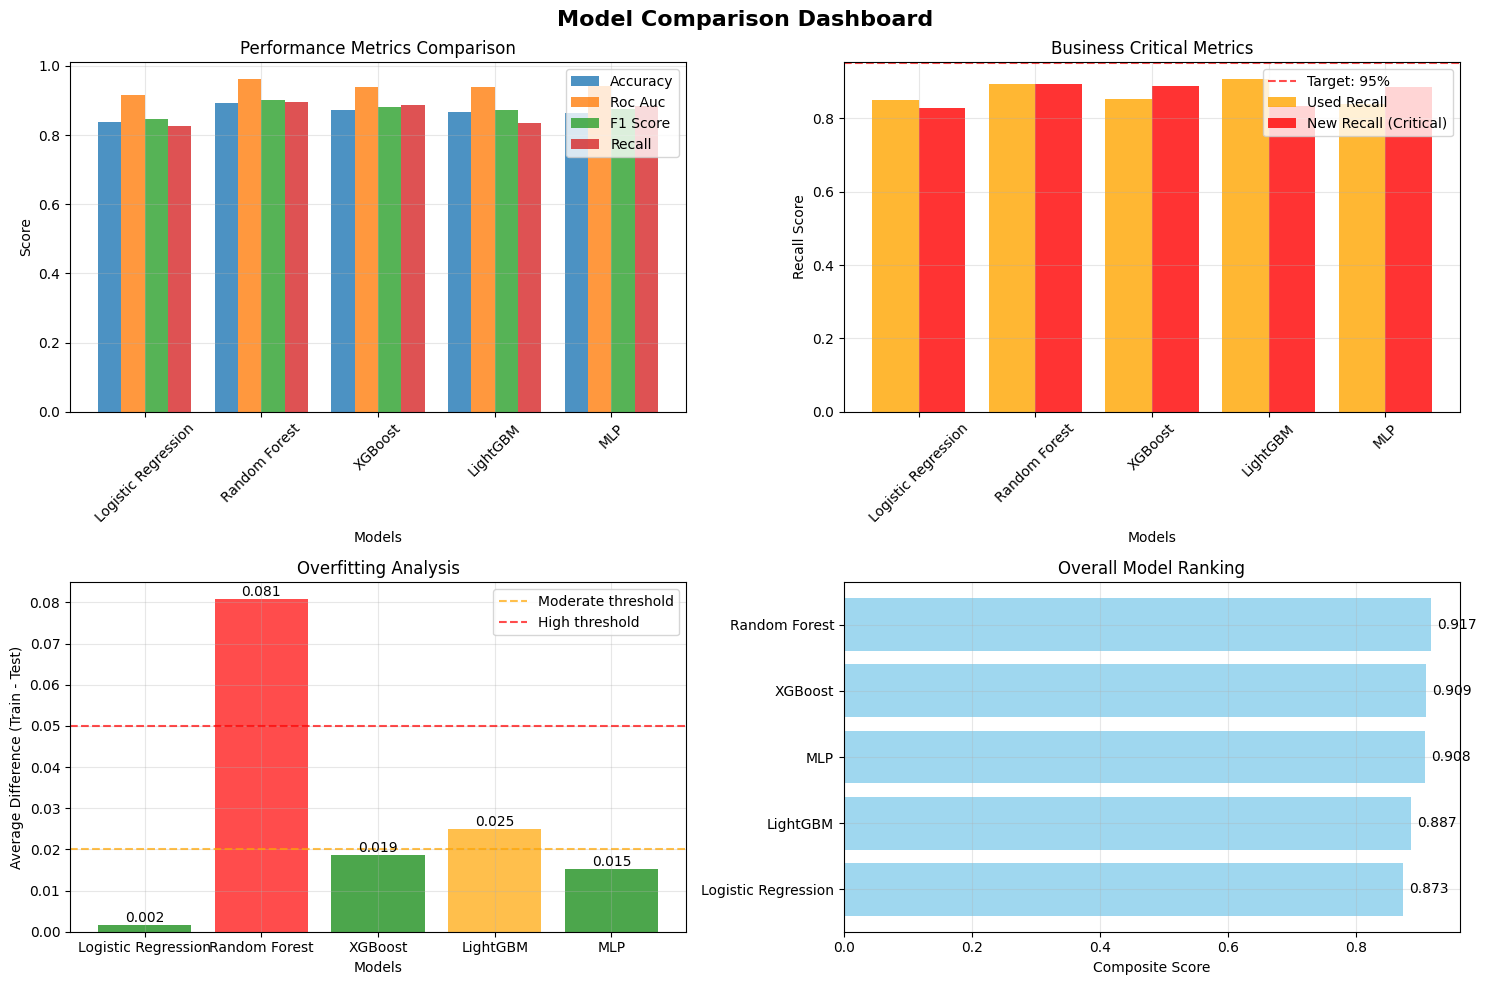


✅ Results saved to ../results/model_comparison_results.csv

                    MODEL EXPERIMENTS COMPLETED


In [10]:
def main():
    """Main execution function"""
    
    print("="*80)
    print("           PRODUCT CONDITION CLASSIFICATION - MODEL EXPERIMENTS")
    print("="*80)
    print("Objective: Find the best model to classify products as 'new' or 'used'")
    print("Critical Business Metric: Minimize new products classified as used")
    print("="*80)
    
    # Load and prepare data
    df_train, df_test, y_train, y_test = load_and_prepare_data()
    
    # Apply feature engineering
    X_train, X_test, pipeline = apply_feature_engineering(df_train, df_test, y_train)
    
    # Define models to test
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline as SklearnPipeline
    
    models = {
        'Logistic Regression': SklearnPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                random_state=42, 
                max_iter=1000, 
                class_weight='balanced'
            ))
        ]),
        'Random Forest': RandomForestClassifier(
            random_state=42, 
            n_estimators=100,
            class_weight='balanced',
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=1,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1
        ),
        'LightGBM': lgb.LGBMClassifier(
            random_state=42,
            verbosity=-1,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            class_weight='balanced'
        ),
        'MLP': SklearnPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', MLPClassifier(
                random_state=42,
                max_iter=500,
                hidden_layer_sizes=(100, 50),
                early_stopping=True,
                validation_fraction=0.1
            ))
        ])
    }
    
    # Train and evaluate all models
    all_metrics = []
    all_predictions = {}
    
    for model_name, model in models.items():
        try:
            # Train model
            trained_model = train_model(model, X_train, y_train, model_name)
            
            # Evaluate model
            metrics, y_pred, y_pred_proba = evaluate_model(
                trained_model, X_train, y_train, X_test, y_test, model_name
            )
            
            # Store results
            all_metrics.append(metrics)
            all_predictions[model_name] = {
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            # Print detailed results
            print_model_evaluation(metrics, y_test, y_pred, y_pred_proba)
            
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue
    
    # Create comprehensive comparison
    if all_metrics:
        df_comparison = create_comparison_table(all_metrics)
        plot_model_comparison(all_metrics)
        
        # Save results
        df_comparison.to_csv('../results/model_comparison_results.csv', index=False)
        print(f"\n✅ Results saved to ../results/model_comparison_results.csv")
    else:
        print("❌ No models were successfully trained!")
    
    print(f"\n{'='*80}")
    print("                    MODEL EXPERIMENTS COMPLETED")
    print(f"{'='*80}")


if __name__ == "__main__":
    main() 